
# Trabajo Práctico 2


Descargar el dataset **Facebook comment volume** https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset. 

El dataset tiene diferentes versiones, utilizaremos la **número 5** para train y para test **Features_TestSet**. 

Notar que trae **carpeta de train y de test**. 

Una descripcióm completa del dataset pueden encontrarla en el link. Se trata de publicaciones de Facebook y se quiere **predecir la columna 54: cantidad de comentarios en las próximas H horas"**.

El dataset contiene variables en muchos formatos diferentes, algunos de los cuales no hemos trabajado o no lo hemos hechos en profundidad. Esas variables pueden ser descartadas o bien hacer una investigación personal para ver de qué manera poder incluirlas para mejorar los resultados obtenidos.



# Importar librerías

Importar aquellas librerías que serán utilizadas en el trabajo.

In [3]:
import pandas as pd
import numpy as np
import math
import collections
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.random.seed(0)
rand_state = 0

# Cargar datos
Cargar los datos de entrenamiento.

In [4]:
dataset = pd.read_csv("Datasets/Features_Variant_5.csv", header = None)
test = pd.read_csv("Datasets/Features_TestSet.csv")

In [5]:
train_x = dataset.iloc[:,:-1]
train_y = dataset.iloc[:,53]

In [6]:
train_y

0           0
1           0
2           0
3           0
4           0
         ... 
199025    203
199026     42
199027     51
199028     17
199029     21
Name: 53, Length: 199030, dtype: int64

# Análisis exploratorio básico y preprocesamiento de los datos

Análisis de los datos para conocer los mismos, ver datos faltantes, decidir cómo tratarlos, ver distribuciones, relaciones, etc. Procesar los datos centrándolos, reescalando, codificando, etc. según considere necesario. 

In [7]:
# Defino número de filas y columnas
nrow = len(train_x)
ncol = len(train_x.T)

In [8]:
# Chequeo si hay valores faltantes
train_x.isnull().values.any()

False

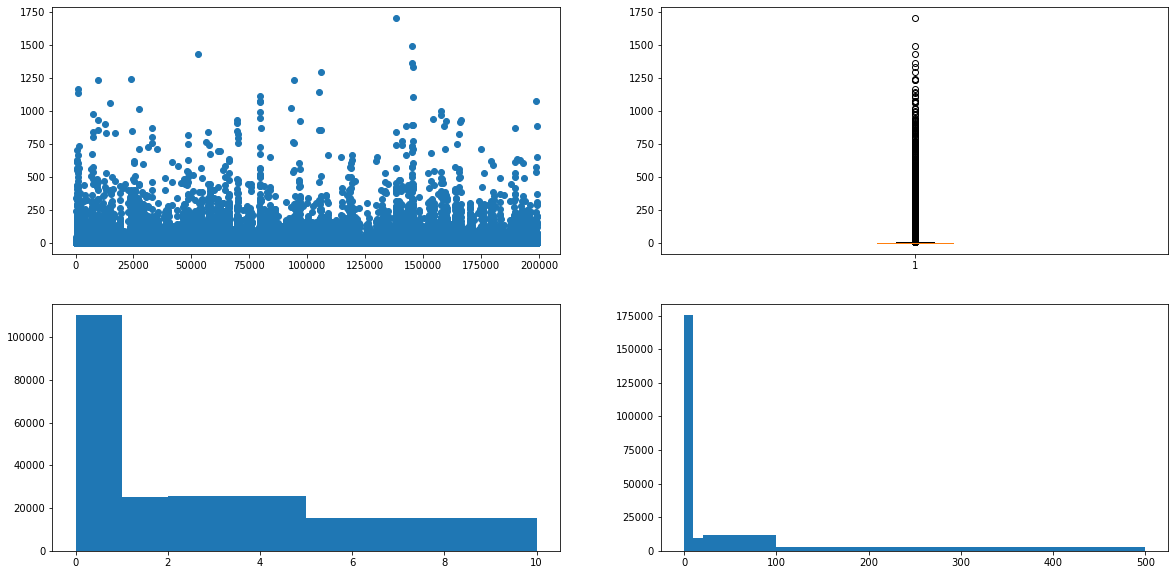

In [9]:
# Grafico la variablle a predecir
fig, ax = plt.subplots(2,2, figsize = (20,10))
ax[0,0].scatter(np.arange(0,nrow), train_y)
ax[0,1].boxplot(train_y)
ax[1,0].hist(train_y, bins = [0, 1, 2, 5, 10])
ax[1,1].hist(train_y, bins = [0, 10, 20, 100, 500])
plt.show;

* Quise visualizar la variable a predecir como dispersión para ver qué valores tomaba; como boxplot para ver outliers; y como histograma para ver valores más frecuentes

In [10]:
# Cuento la cantidad de repeticiones de la variable Y.
counter = collections.Counter(train_y)
counter_vec = [counter[i] for i in range(nrow)]
propcum = np.cumsum(np.array(counter_vec)/nrow)

In [11]:
# Hago una prueba y veo que el 90% de la variable Y son valores con 13 comentarios o menos.
prop = 0.97
cant = min([i for i in range(nrow) if propcum[i] >= prop])
prop = propcum[cant]

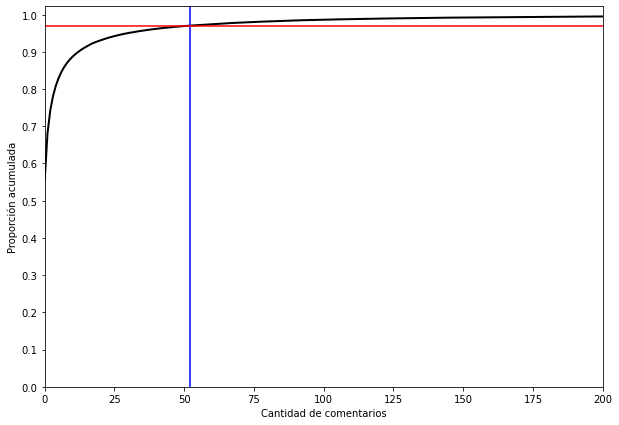

In [12]:
# Grafico la proporción acumulada de la muestra en función de la cantidad de comentarios
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(propcum, color = "k", lw = 2)
ax.set_xlabel('Cantidad de comentarios')
ax.set_ylabel('Proporción acumulada')
ax.set_xlim(0,200)
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.axvline(cant, c = 'b')
plt.axhline(prop, c = 'r')
plt.show();

In [13]:
# Creo vector para identificar cantidad de valores diferentes de cada columna
difvals = [len(np.unique(train_x.iloc[:,i])) for i in range(ncol)]

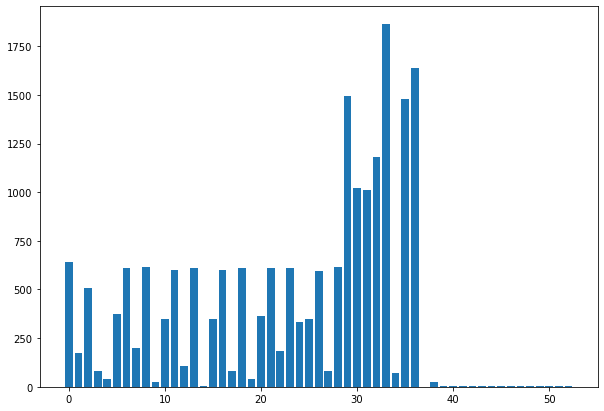

In [14]:
# Grafico la cantidad de valores diferentes para cada variable
fig, ax = plt.subplots(figsize = (10,7))
ax.bar(np.arange(0,ncol), difvals)
plt.show;

In [15]:
# Identifico variables con un solo valor
[i for i in range(ncol) if difvals[i] == 1]

[37]

* La columna 37 adopta sólo un valor (el valor 0). Puede borrarse esta columna y el modelo de predicción sería idénticamente igual.

In [16]:
# Identifico variables dicotómicas
[i for i in range(ncol) if difvals[i] == 2]

[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]

* Las columnas 39 a 52 corresponden a variables dicotómicas.

In [17]:
# Identifico variables con 3 valores
[i for i in range(ncol) if difvals[i] == 3]

[14]

In [18]:
np.unique(train_x.iloc[:,14])

array([  0., 113., 148.])

* La columna 14 solo adopta valores 0, 113 o 148.

In [19]:
np.arange(0,39)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [20]:
# Estandarizo columnas
scaler = StandardScaler()
train_x_scaled = np.hstack([scaler.fit_transform(train_x.iloc[:,0:39]),train_x.iloc[:,39:ncol]])
train_y_scaled = scaler.fit_transform(np.array(train_y).reshape(-1, 1))

* Solo estandaricé variables continuas, no dicotómicas.

In [21]:
# Chequeo que se haya realizado correctamente la estandarización (X)
colmeans = np.array([np.mean(train_x_scaled[:,i]) for i in range(ncol)])
True in [i == 0 for i in abs(np.round(colmeans, 5))]

True

In [22]:
# Chequeo que se haya realizado correctamente la estandarización (Y)
0 == abs(np.round(np.mean(train_y_scaled), 5))

True

# Modelos y evaluación
Probar diferentes modelos para predecir la variable objetivo. Calcular las métricas que considere relevantes. Comentar los resultados. 

* Quiero probar aplicar PCA únicamente para ver a cuántas componentes puede reducirse.
* Esto me da una noción de la correlación de las variables

### Aplico PCA

In [23]:
# Quiero capturar el 90% de la varianza
pca = PCA(n_components = 0.90, random_state = rand_state).fit(train_x_scaled)
pca_train = pca.transform(train_x_scaled)
pca_full = PCA(n_components = ncol, random_state = rand_state).fit(train_x_scaled)

In [24]:
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

In [25]:
# Con solo 13 variables, logramos contemplar el 93% de la varianza.
ncomp = pca_train.shape[1]
var = cumvar[ncomp]
ncomp, var

(13, 0.9224557181875485)

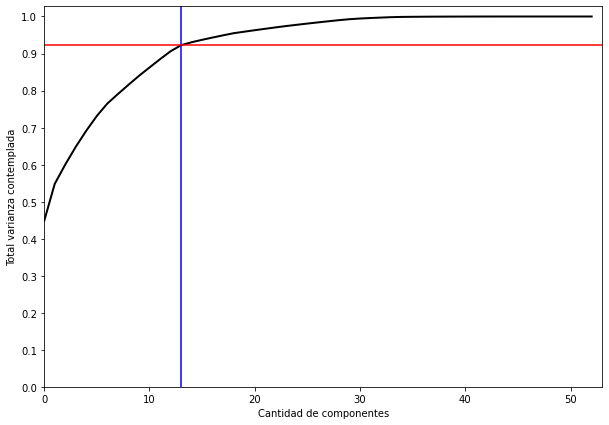

In [26]:
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(cumvar, color = "k", lw = 2)
ax.set_xlabel('Cantidad de componentes')
ax.set_ylabel('Total varianza contemplada')
ax.set_xlim(0,ncol)
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.axvline(ncomp, c = 'b')
plt.axhline(var, c = 'r')
plt.show();

### Planteo un modelo de regresión lineal

In [27]:
# Pendiente de la recta
m = np.linalg.inv(pca_train.T @ pca_train) @ pca_train.T @ train_y

In [28]:
# Pendiente y ordenada al origen de la recta
aug_pca_train = np.vstack([np.ones(nrow), pca_train.T]).T
b = np.linalg.inv(aug_pca_train.T @ aug_pca_train) @ aug_pca_train.T @ train_y

In [29]:
# Calculo las predicciones
pred_1 = aug_pca_train[:,[0,1]] @ b[[0,1]]
pred_21 = aug_pca_train @ b

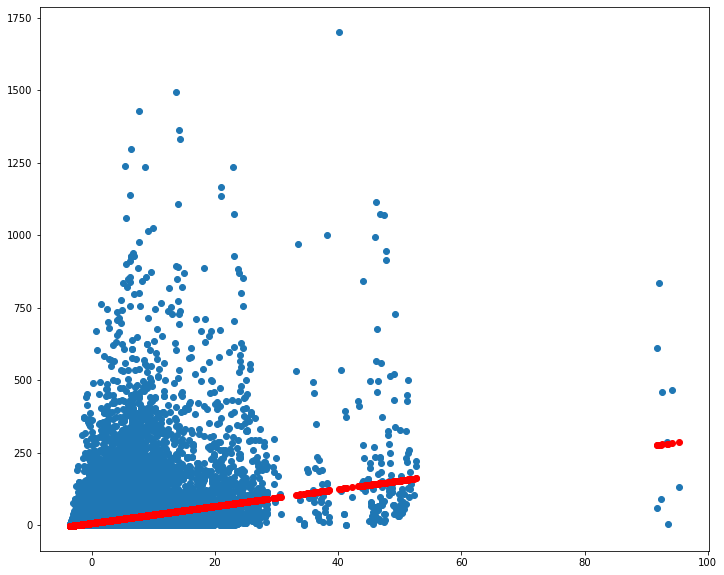

In [30]:
# Grafico la variablle a predecir en función de la componente principal
fig, ax = plt.subplots(figsize = (12,10))
ax.scatter(pca_train[:,0], train_y)
ax.scatter(pca_train[:,0], pred_1 , c = "r")
plt.show;

* Si bien la primera componente recoge el 46% de la varianza, no alcanza a estimar bien la variable a predecir con un modelo lineal.

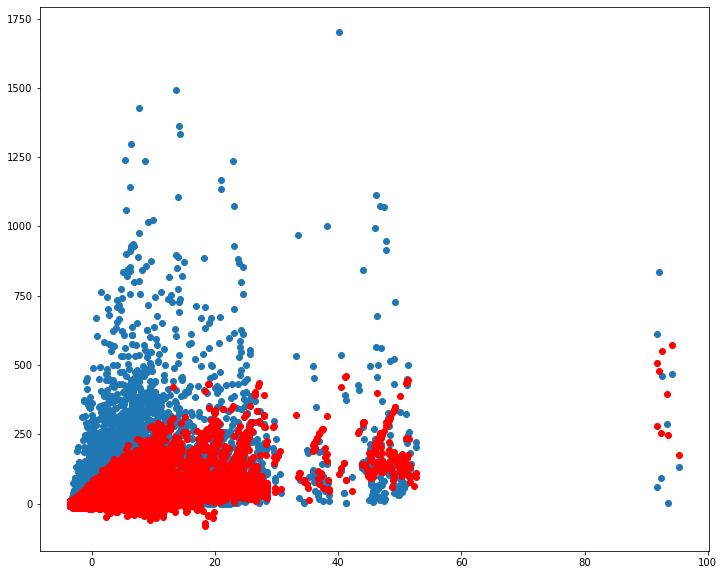

In [31]:
# Grafico la variablle a predecir en función de las 13 componentes principales
fig, ax = plt.subplots(figsize = (12,10))
ax.scatter(pca_train[:,0], train_y)
ax.scatter(pca_train[:,0], pred_21, c = "r")
plt.show;

* Con 13 componentes el modelo se comporta mejor, pero no alcanza a ajustar bien. 
* Con esto podemos asumir que el modelo lineal no es bueno en este caso, y habría que probar con uno no lineal.

In [32]:
# Calculo el R2
reg = sum([(pred_21[i]-np.mean(train_y))**2 for i in range(nrow)])
res = sum([(train_y[i]-pred_21[i])**2 for i in range(nrow)])

In [33]:
R2 = 1-res/(res+reg)
R2

0.32694457255582

* El R2, que puede entenderse como la proporción de la varianza explicada por el modelo, es de 0.32. 
* Un número bastante malo, que refeurza la noción visual que mostraron los gráficos anteriores.

### Planteo un modelo de regresión polinómica

* A continuación defino una funcioón para que me calcule los cuadrados y cubos de las variables, me separe entre variables continuas y binarias, y me estandarice sólo las continuas.

In [34]:
def poly(data):
    
        ncol = len(data.T)
        nrow = len(data)
        new_data_no_dic = np.zeros(nrow)
        new_data_no_dic = np.reshape(new_data_no_dic, (nrow, 1))
        scaler = StandardScaler()
        data = np.array(data)
        
        difvals = [len(np.unique(data[:,i])) for i in range(ncol)]
            
        single_var = [i for i in range(ncol) if difvals[i] == 1]
        dic_var = [i for i in range(ncol) if difvals[i] == 2]
        
        to_keep = set(np.arange(0, ncol)) - set(dic_var) - set(single_var)
        
        data_no_dic = scaler.fit_transform(data[:,np.array(list(to_keep))])
        data_dic = data[:,np.array(list(dic_var))]
        
        ncol = len(data_no_dic.T)
        
        for i in range(ncol):
            c1 = data_no_dic[:,i]
            c2 = data_no_dic[:,i]**2
            c3 = data_no_dic[:,i]**3
            c = np.vstack([c1,c2,c3]).T
            new_data_no_dic = np.hstack([new_data_no_dic,c])
    
        new_data_no_dic = new_data_no_dic[:,1:]
        
        #new_data = np.hstack([scaler.fit_transform(new_data[:,np.array(list(to_keep))]),new_data[:,np.array(list(dic_var))]])

        return new_data_no_dic, data_dic

* A continuación defino una función para que mne calcule el vector de coeficientes con término independiente, con un determinado lambda para regularizar.

In [80]:
def model(x, y, t):
    nrow = len(x)
    aug_mat = np.vstack([np.ones(nrow), x.T]).T
    A = t * np.identity(len(aug_mat.T))
    A[0,0] = 0
    b = np.linalg.inv(aug_mat.T @ aug_mat + A) @ aug_mat.T @ y
    preds = aug_mat @ b
    
    return b, preds

In [81]:
def predict(x, b):
    nrow = len(x)
    aug_mat = np.vstack([np.ones(nrow), x.T]).T
    preds = aug_mat @ b
    
    return preds

In [36]:
new_data = poly(train_x)

In [37]:
b, preds = model(np.hstack([new_data[0], new_data[1]]), train_y, 0)

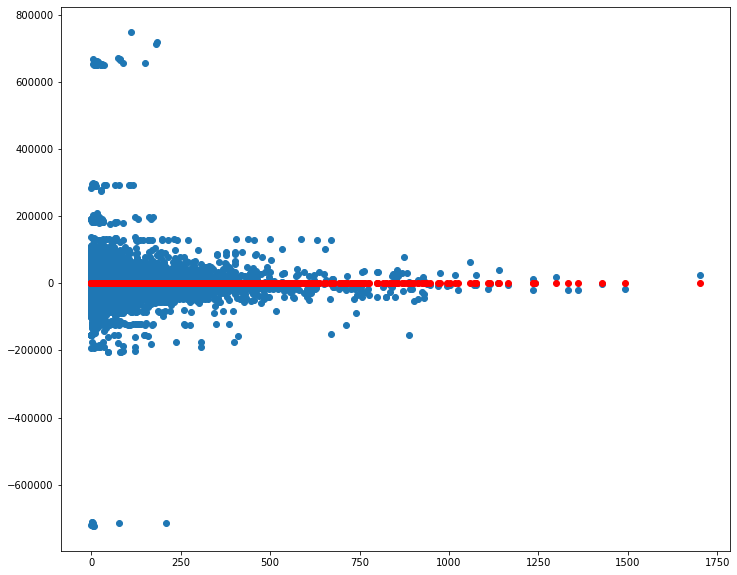

In [38]:
# Grafico la variablle a predecir en función de su valor REAL.
fig, ax = plt.subplots(figsize = (12,10))
ax.scatter(train_y, preds)
ax.scatter(train_y, train_y, c = "r")
plt.show;

* Este es el modelo de regresión polinómica sin regularizar, es decir, con un hiperparámetro lambda = 0.
* Se nota demasiada dispersión. El modelo es altamente sensible.

In [39]:
# Calculo el R2
reg_p = sum([(preds[i]-np.mean(train_y))**2 for i in range(nrow)])
res_p = sum([(train_y[i]-preds[i])**2 for i in range(nrow)])

In [40]:
R2_p = 1-res_p/(res_p+reg_p)
R2_p

0.4999903425743508

### Elijo el mejor lambda

In [41]:
v = []
lambdas = [i**12 for i in np.log10(np.arange(1, 20, 1))]
for i in lambdas:
    b, preds = model(new_data[0], train_y, i)
    e = sum([(preds[t]-train_y[t])**2 for t in range(nrow)])
    r = [i, e]
    v.append(r)

v = np.array(v)[1:]

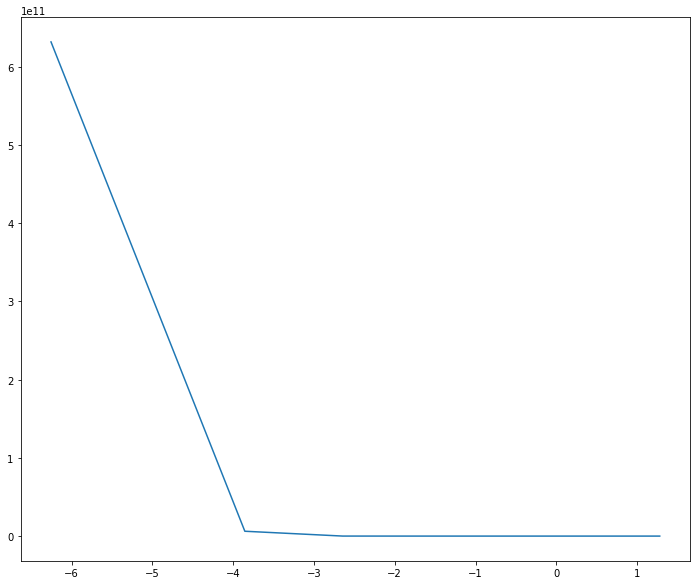

In [42]:
# Grafico el error en función del lambda escogido
fig, ax = plt.subplots(figsize = (12,10))
ax.plot(np.log10(v.T[0]), v.T[1])
plt.show;

In [43]:
index = np.where(v.T[1] == min(v.T[1]))
best_lambda = v[index][0][0]

In [44]:
b, preds = model(np.hstack([new_data[0], new_data[1]]), train_y, best_lambda)

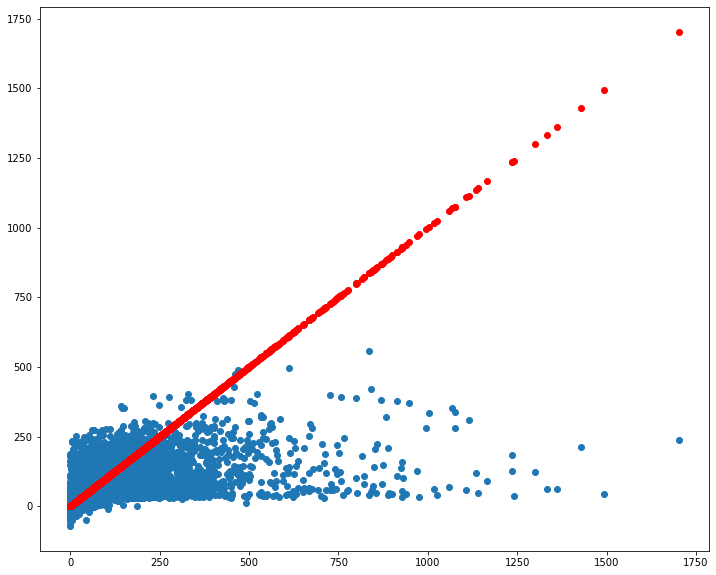

In [45]:
# Grafico la variablle a predecir con el mejor lambda
fig, ax = plt.subplots(figsize = (12,10))
ax.scatter(train_y, preds)
ax.scatter(train_y, train_y, c = "r")
plt.show;

In [46]:
# Calculo el R2
reg_p = sum([(preds[i]-np.mean(train_y))**2 for i in range(nrow)])
res_p = sum([(train_y[i]-preds[i])**2 for i in range(nrow)])

In [47]:
R2_p = 1-res_p/(res_p+reg_p)
R2_p

0.4081382922529043

* El modelo mejoró bastante agregando un término de regularización. Sin embargo, yerra demasiado cuando intenta predecir valores altos de comentarios

### Dataset quitando outliers (< 50 comentarios - 97% de la muestra)

In [51]:
# Filtro vector Y con al menos 1 comentario
indexes = [i for i in range(len(train_y)) if train_y[i] >= 0 and train_y[i] < 1200]
train_y_2 = np.array(train_y[indexes])
train_x_2 = train_x.iloc[indexes,:]

In [52]:
new_data_2 = poly(train_x_2)

In [53]:
v = []
lambdas = [i**15 for i in np.log10(np.arange(1, 50, 2))]
nrow = len(train_y_2)
for i in lambdas:
    b, preds = model(new_data_2[0], train_y_2, i)
    e = sum([(preds[t]-train_y_2[t])**2 for t in range(nrow)])
    r = [i, e]
    v.append(r)

v = np.array(v)[1:]

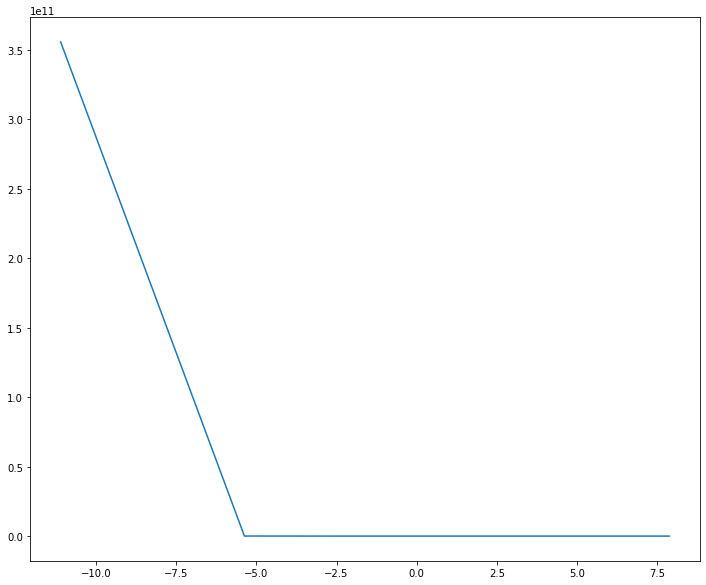

In [54]:
# Grafico el error en función del lambda escogid
fig, ax = plt.subplots(figsize = (12,10))
ax.plot(np.log(v.T[0]), v.T[1])
plt.show;

In [55]:
index = np.where(v.T[1] == min(v.T[1]))
best_lambda = v[index][0][0]

In [56]:
b, preds = model(np.hstack([new_data_2[0], new_data_2[1]]), train_y_2, best_lambda)

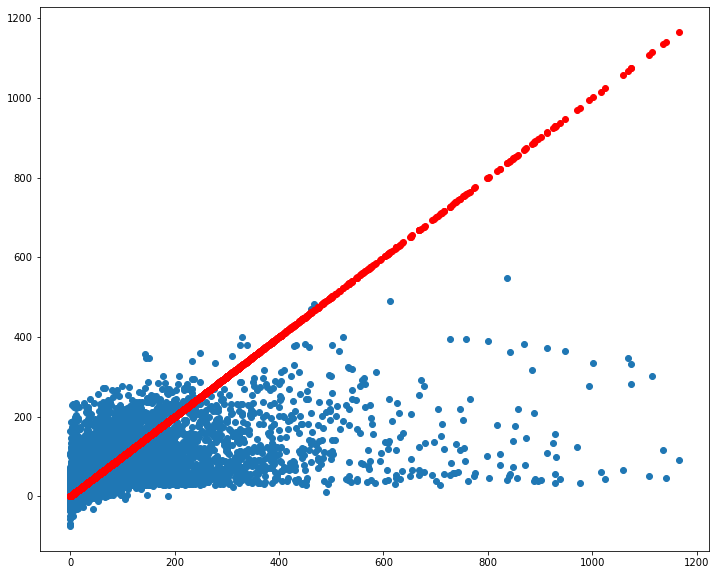

In [57]:
# Grafico la variablle a predecir con el mejor lambda
fig, ax = plt.subplots(figsize = (12,10))
ax.scatter(train_y_2, preds)
ax.scatter(train_y_2, train_y_2, c = "r")
plt.show;

* Visto de esta manera, es una función de dos variables, en donde la independiente corresponde al valor real y la dependiente corresponde a la predicción.
* Se podría ajustar la prediccón para que "copie" mejor a la función identidad (valores reales).

### Sobre las predicciones recién conseguidas, aplico una correción

In [59]:
def base_correction(x, y):
    adj_preds= []
    max_comments = np.array([np.sort(y)[-1], np.sort(y)[-2], np.sort(y)[-3]])
    min_comments = np.array([np.sort(y)[0], np.sort(y)[1], np.sort(y)[2]])
    upper = min(max_comments) - np.median([x[i] for i in range(len(x)) if y[i] in max_comments]) - 100
    lower = max(min_comments) - np.median([x[i] for i in range(len(x)) if y[i] in min_comments]) - 100
    for i in range(len(x)):
        adj_preds.append(x[i] + ((upper - lower)/(max(max_comments) - min(min_comments)) * y[i] + lower))
    
    return np.array(adj_preds), upper, lower

In [58]:
adj_preds, upper, lower = base_correction(preds, train_y_2)

In [60]:
def correction(x, upper, lower):
    adj_preds = []
    cant = int(len(x) / 2)
    max_comments = np.array([np.sort(x)[-cant:]])
    min_comments = np.array([np.sort(x)[0:cant]])
    #for i in range(len(x)):
        #adj_preds.append(x[i] + ((np.median(max_comments) - np.median(min_comments))/(upper - lower) * (np.mean(x) - lower)  + np.median(min_comments)))
        
    for i in range(len(x)):
        adj_preds.append(x[i] + ((upper - lower)/(np.mean(max_comments) - np.mean(min_comments)) * (x[i] / 10 - np.mean(min_comments)) + lower))
    
    return np.array(adj_preds)

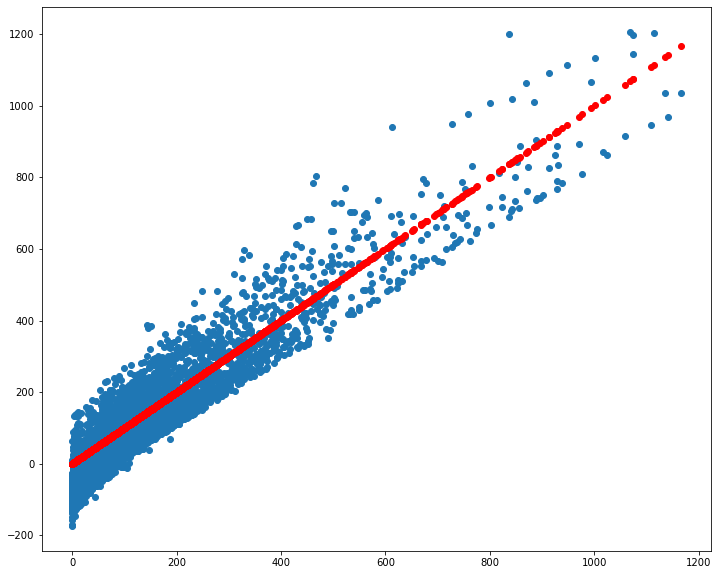

In [61]:
# Grafico la variablle a predecir con el mejor lambda
fig, ax = plt.subplots(figsize = (12,10))
ax.scatter(train_y_2, adj_preds)
ax.scatter(train_y_2, train_y_2, c = "r")
plt.show;

* Podemos ver cómo la corrección funcionó muy bien para el modelo de entrenamiento.
* La corrección se basó en multiplicar al vector predicción por una función lineal que acercaba cada punto al real.

### Evalúo modelo en test

In [120]:
# Cargo los datasets
test_x = test.iloc[:,:-1]
test_y = test.iloc[:,53]

In [121]:
# Calculo las columnas que quité en el dataset original para que sean las mismas
data = np.array(train_x)
ncol = len(data.T)

difvals = [len(np.unique(data[:,i])) for i in range(ncol)]
single_var = [i for i in range(ncol) if difvals[i] == 1]
dic_var = [i for i in range(ncol) if difvals[i] == 2]

In [122]:
# Defino una función para que me identifique las columnas con variables continuas y binarias, y me escale sólo las continuas
def pred_poly(data, single, dic):
    
        ncol = len(data.T)
        nrow = len(data)
        new_data_no_dic = np.zeros(nrow)
        new_data_no_dic = np.reshape(new_data_no_dic, (nrow, 1))
        scaler = StandardScaler()
        data = np.array(data)
        
        to_keep = set(np.arange(0, ncol)) - set(dic) - set(single)
        
        data_no_dic = scaler.fit_transform(data[:,np.array(list(to_keep))])
        data_dic = data[:,np.array(list(dic_var))]
        
        ncol = len(data_no_dic.T)
        
        for i in range(ncol):
            c1 = data_no_dic[:,i]
            c2 = data_no_dic[:,i]**2
            c3 = data_no_dic[:,i]**3
            c = np.vstack([c1,c2,c3]).T
            new_data_no_dic = np.hstack([new_data_no_dic,c])
    
        new_data_no_dic = new_data_no_dic[:,1:]        

        return np.hstack([new_data_no_dic, data_dic])

In [112]:
test_data = pred_poly(test_x, single_var, dic_var)

In [123]:
# Calculo las predicciones nuevas
new_preds = predict(test_data, b)

In [124]:
# Calculo las predicciones corregidas
new_adj_preds = correction(new_preds, upper, lower)

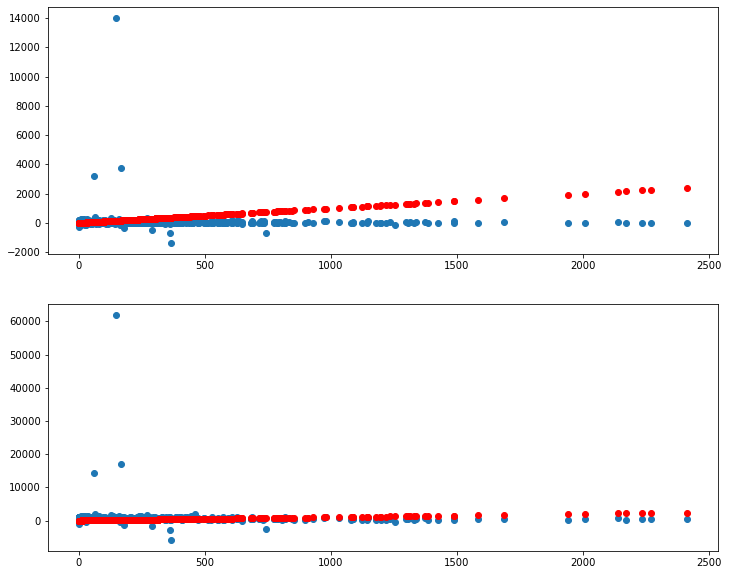

In [119]:
# Grafico las predicciones normales y corregidas
fig, ax = plt.subplots(2, figsize = (12,10))
ax[0].scatter(test_y, new_preds)
ax[0].scatter(test_y, test_y, c = "r")

ax[1].scatter(test_y, adj_preds)
ax[1].scatter(test_y, test_y, c = "r")

plt.show;

* El primer gráfico muestra una regrrsión polinómica regularizada con ridge, y el 2do gráfico es el mismo de arriba, pero con la función de corrección.
* Se ve una notable mejora, pero los outliers distorisionan la escala

### Última corrección

* Por último, se va a corregir cualquier valor que pueda ser un outlier; y los valores negativos, que serán tomados como cero

In [139]:
def def_predict(x, b, upper, lower):
    nrow = len(x)
    aug_mat = np.vstack([np.ones(nrow), x.T]).T
    preds = aug_mat @ b
    ceiling = 1500
    
    adj_preds = correction(preds, upper, lower)  
       
    def_preds = [min(adj_preds[i], ceiling) for i in range(nrow)]
    def_preds = [max(def_preds[i], 0) for i in range(nrow)]   
    
    return def_preds

In [140]:
def_preds = def_predict(test_data, b, upper, lower)

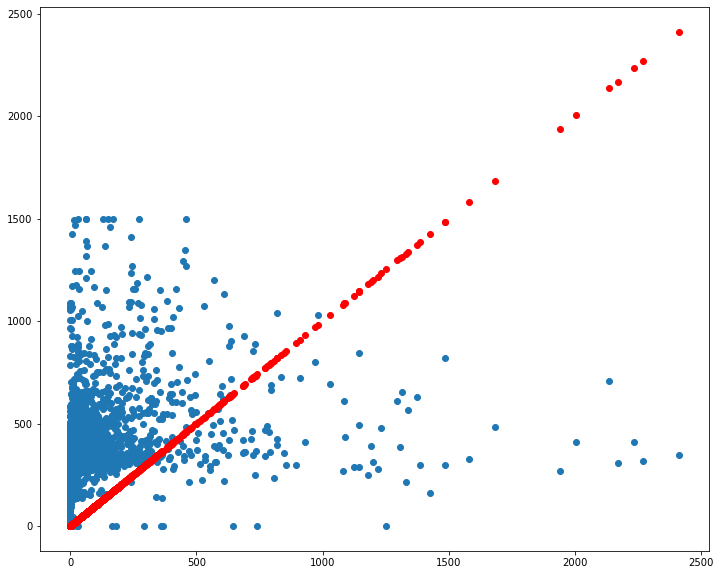

In [141]:
# Grafico las predicciones normales y corregidas
fig, ax = plt.subplots(figsize = (12,10))
ax.scatter(test_y, def_preds)
ax.scatter(test_y, test_y, c = "r")

plt.show;

* Por si no se entendió, los puntos rojos corresponden a la función identidad. Esto es lógico, puesto que tanto la variable X como la Y son iguales, que corresponden al valor real.
* Entonces, la idea siempre fue intentar alcanzar una buena tendencia, en donde los puntos azules se "peguen cada vez más" a la recta roja. 
* Me apreció una buena manera de visualizar el problema para reducirlo a 2 variables.

### Conclusiones finales

* Vemos cómo el modelo fue mejorando conforme se fueron puliendo más aspectos.
* El modelo sobredimensiona bastante para los valores de bajos comentarios, y se queda corto en las predicciones con muchos comentarios.
* Es esperable que algo así ocurra, ya que la mayor cantidad de datos son para menos de 50 comentarios (97%).
* Posiblemente, encarando el problema con otro algoritmo, como áboles de decisión o una red neuronal, se hubiese conseguido mejores resultados.
* De todas maneras, es muy interesante saber que con una combinación de lineal de las features se pueden conseguir valores aproximados, además de que arroja resultados muy rápidos.